# Center points generation: Dynamic System Approach

In [60]:
%matplotlib inline

import sys
import numba
#import matlab.engine
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
from math import sqrt, log, floor, ceil
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable


# acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import load_fits, standarize

# extra metric module
import custom_metric as cm

In [7]:
def points_plot(data, center_points=None, collocation_points=None, boundary_points=None):
    if (center_points is not None) and (collocation_points is None):
        plt.figure(figsize=(8,8))
        plt.imshow(data)
        plt.scatter(center_points[:,0]*99, center_points[:,1]*99, c='r', s=5, label='center')
        plt.title('Center points')
        plt.axis('off')
    elif (center_points is None) and (collocation_points is not None):
        plt.figure(figsize=(8,8))
        plt.imshow(data)
        plt.scatter(collocation_points[:,0]*99, collocation_points[:,1]*99, c='g', s=5, label='collocation')
        plt.title('Collocation points')
        plt.axis('off')
    elif (center_points is not None) and (collocation_points is not None):
        fig = plt.figure(figsize=(20,15))
        ax1 = fig.add_subplot(121)
        ax1.imshow(data)
        ax1.scatter(center_points[:,0]*99, center_points[:,1]*99, c='r', s=5, label='center')
        ax1.set_title('Center points')
        ax1.axis('off')
        ax2 = fig.add_subplot(122)
        ax2.imshow(data)
        ax2.scatter(collocation_points[:,0]*99, collocation_points[:,1]*99, c='g', s=5, label='collocation')
        ax2.set_title('Collocation points')
        ax2.axis('off')
    if (boundary_points is not None) and len(boundary_points[:,0])!=0:
        plt.figure(figsize=(8,8))
        plt.imshow(data)
        plt.scatter(boundary_points[:,0]*99, boundary_points[:,1]*99, c='y', s=5, label="boundary")
        plt.axis('off')
    #plt.colorbar(im, cax=cax)
    #fig.legend(bbox_to_anchor=(1.2, 1.0))
    plt.show()

## Loading 2D Data

In [8]:
"""
Loading data
"""

#fit_path = '../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
#fit_path = '../../bindata/fits/cubes/M100line.image.fits'
fit_path = '../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'
#fit_path = '../../bindata/fits/cubes/ALMA01000740.fits'
container = load_fits(fit_path)
data = standarize(container.primary)[0]
data = data.data

#stacking it
data = data.sum(axis=0)
data /= data.max()

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


In [9]:
"""
Generating the data function
"""
x = np.linspace(0., 1., len(data[0]), endpoint=True)
y = np.linspace(0., 1., len(data[1]), endpoint=True)
dfunc = sp.interpolate.interp2d(x, y, data, kind='linear')

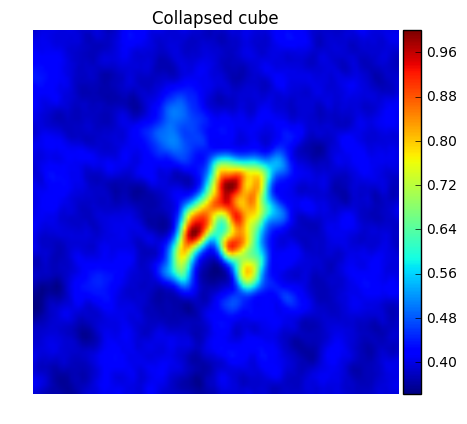

In [75]:
plt.figure(figsize=(5,5))
im = plt.imshow(data)
plt.title('Collapsed cube')
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

## Computing image gradient: (Finite differences)

In [523]:
gx, gy = np.gradient(data)

In [524]:
"""
Generating the gradient data function
"""
x = np.linspace(0., 1., len(data[0]), endpoint=True)
y = np.linspace(0., 1., len(data[1]), endpoint=True)
gx_func = sp.interpolate.interp2d(x, y, gx, kind='linear')
gy_func = sp.interpolate.interp2d(x, y, gy, kind='linear')

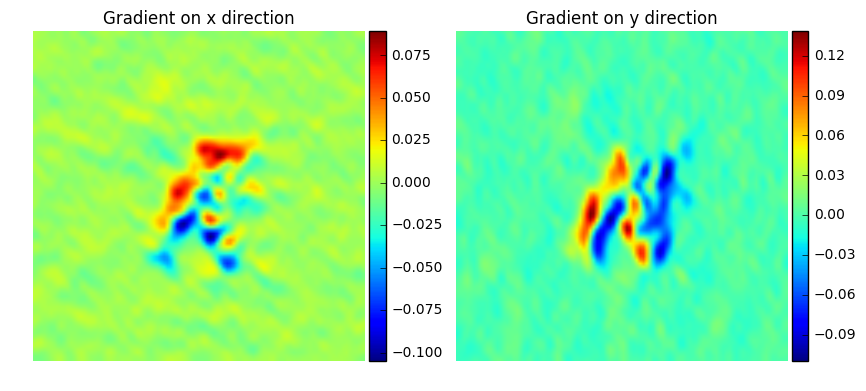

In [525]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
im = plt.imshow(gx)
plt.title('Gradient on x direction')
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.subplot(1,2,2)
im = plt.imshow(gy)
plt.title('Gradient on y direction')
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

## Center points generation: Dynamic Approach

In [526]:
2. / (1. + np.exp(((1.3*(2-2))**2)))

1.0

In [539]:
def R(x):
    ret = np.empty(x.shape)
    mask0 = x<2.
    mask1 = x>=2.
    ret[mask0] = np.cos(np.pi/2 * x[mask0])
    ret[mask1] = -2 / (1. + np.exp(((3.*(x[mask1]-2))**2)))
    return -1.*ret

def d(x, sigmin=0.05, sigmax=2.):
    alpha = -np.log(sigmin/sigmax)
    return sigmax * np.exp(-alpha * x)
    

class APoints():
    def __init__(self, n_points, dfunc, gx_func, gy_func, eps=1e-4, alpha=2.):
        self.n_points = n_points
        self.dfunc = dfunc
        self.gx_func = gx_func
        self.gy_func = gy_func
        self.alpha = alpha
        self.eps = eps
  
    def F(self, points, t=0.):
        points = points.reshape((self.n_points,2))
        # distance matrices
        Dx = np.empty((self.n_points, self.n_points))
        Dy = np.empty((self.n_points, self.n_points))
        for i in range(points.shape[0]):
            Dx[i] = points[:,0] - points[i,0] 
            Dy[i] = points[:,1] - points[i,1]
        D = np.sqrt(Dx**2 + Dy**2) + self.eps
        # intensities at each point
        I = np.diagonal(self.dfunc(points[:,0], points[:,1]))
        # gradients at each point
        Gx = np.diagonal(self.gx_func(points[:,0], points[:,1]))
        Gy = np.diagonal(self.gy_func(points[:,0], points[:,1]))
        # computing derivatives
        tmp = (1./self.n_points) * R(D / d(I))
        tmp /= D
        # dd = np.sqrt(points[:,0]**2 + points[:,1]**2)
        dX = (Dx * tmp).sum(axis=1) #- 0.5* points[:,0]/(dd+self.eps) 
        dY = (Dy * tmp).sum(axis=1) #- 0.5* points[:,1]/(dd+self.eps)
        ret = np.vstack([dX+ self.alpha*Gx, dY+ self.alpha*Gy]).T
        return ret.ravel()

$$
R(x) = - \begin{cases} 
      \cos(\frac{\pi}{2} x) &  0 \leq x < 2 \\
      \frac{-2}{1 + e^{(x-2)^2}} & 2 \leq x
\end{cases}
$$

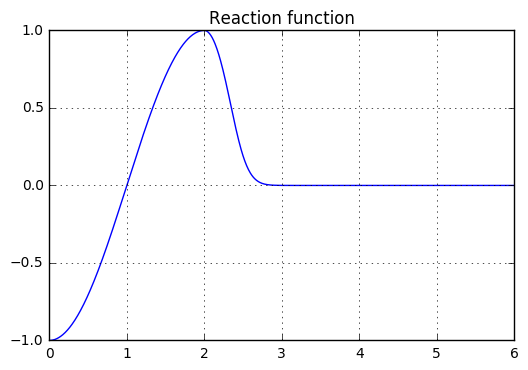

In [540]:
xgrid = np.linspace(0., 6., 1000)
plt.plot(xgrid, R(xgrid))
plt.title('Reaction function')
plt.grid()
plt.show()

**Note**: Remember that the intensity values are bounded in the $[0,1]$ interval.

$$
d(I) = \sigma_{\text{max}} e^{-\alpha I} \ \ \ \ \ \text{with} \ \ \ \ \alpha = - \ln \left(\frac{\sigma_{\text{min}}}{\sigma_{\text{max}}}\right)
$$

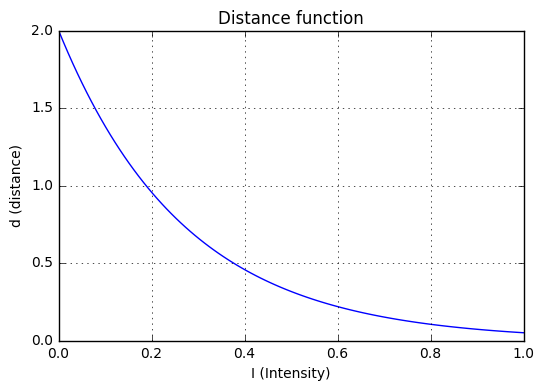

In [541]:
xgrid = np.linspace(0., 1., 100)
plt.plot(xgrid, d(xgrid))
plt.title('Distance function')
plt.xlabel('I (Intensity)')
plt.ylabel('d (distance)')
plt.grid()
plt.show()

### Testing: Uniform Grid as initial state

In [542]:
_xe = np.linspace(0., 1., 17)[1:-1]
_ye = np.linspace(0., 1., 17)[1:-1]
Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
xe = Xe.ravel(); ye = Ye.ravel()
center_points = np.hstack((xe.reshape(-1,1), ye.reshape(-1,1)))

In [563]:
ap = APoints(center_points.shape[0], dfunc, gx_func, gy_func, alpha=20.)

In [552]:
#ap.F(center_points.ravel())

In [553]:
#%timeit ap.F(center_points.flatten())

In [564]:
time_grid = np.linspace(0., 1., 100)
sol = sp.integrate.odeint(ap.F, center_points.flatten(), time_grid)

/home/martin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


In [565]:
pp = sol[-1].reshape((center_points.shape[0], 2))

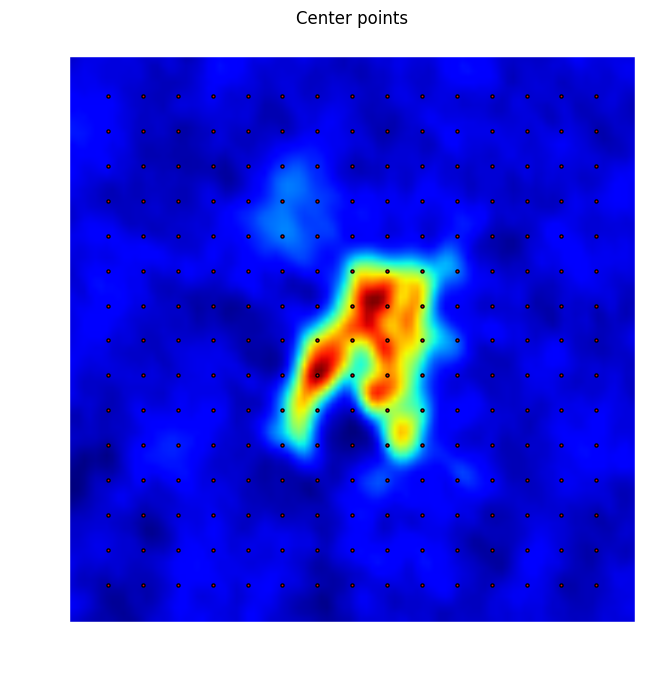

In [566]:
points_plot(data, center_points=center_points)

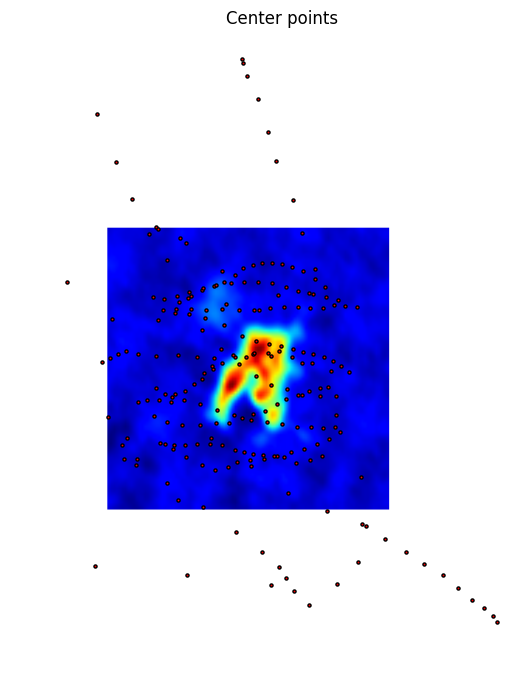

In [567]:
points_plot(data, center_points=pp)

In [568]:
pp.shape

(225, 2)

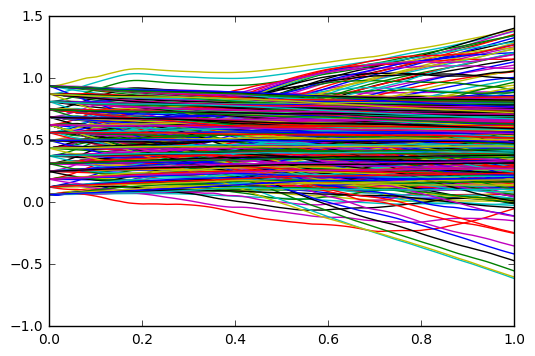

In [569]:
plt.figure()
for i in range(pp.shape[0]*2):
    s = sol[:,i]
    plt.plot(time_grid,s)

## Fixed centers

In [226]:
fp = np.array([[0.44,0.55], [0.54,0.43], [0.55,0.59], [0.59, 0.66], 
               [0.56, 0.51], [0.6,0.45], [0.375,0.30] ,[0.38,0.23]])

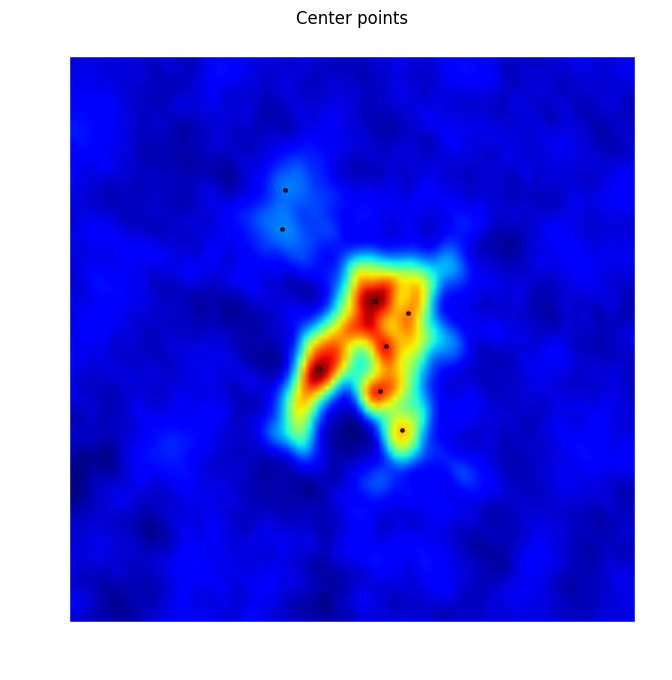

In [227]:
points_plot(data, center_points=fp)

In [308]:
d(0.3)

0.66132051954956861

In [634]:
class APoints():
    def __init__(self, n_points, dfunc, gx_func, gy_func, n_fixed, eps=1e-10, alpha=2.):
        self.n_points = n_points
        self.dfunc = dfunc
        self.gx_func = gx_func
        self.gy_func = gy_func
        self.alpha = alpha
        self.eps = eps
        self.n_fixed = n_fixed
  
    def F(self, points, t=0.):
        points = points.reshape((self.n_points,2))
        # distance matrices
        Dx = np.empty((self.n_points, self.n_points))
        Dy = np.empty((self.n_points, self.n_points))
        for i in range(points.shape[0]):
            Dx[i] = points[:,0] - points[i,0] 
            Dy[i] = points[:,1] - points[i,1]
        D = np.sqrt(Dx**2. + Dy**2.) + self.eps
        dmin = (D + 100*np.identity(D.shape[0])).min(axis=1)
        # intensities at each point
        I = np.diagonal(self.dfunc(points[:,0], points[:,1]))
        G = (1.+I)**4
        # gradients at each point
        #Gx = np.diagonal(self.gx_func(points[:,0], points[:,1]))
        #Gy = np.diagonal(self.gy_func(points[:,0], points[:,1]))
        # computing derivatives
        tmp = (dmin**2) * R(D / d(I))
        G = 1.
        tmp = tmp * G
        #tmp[:,-self.n_fixed:] *= 4.
        #print(tmp)
        #tmp /= D
        #print(tmp)
        # dd = np.sqrt(points[:,0]**2 + points[:,1]**2)
        dX = ((Dx/D) * tmp).sum(axis=1) / G #- 0.5* points[:,0]/(dd+self.eps)
        #dX[-self.n_fixed:] = 0.
        dY = ((Dy/D) * tmp).sum(axis=1) / G #- 0.5* points[:,1]/(dd+self.eps)
        #dY[-self.n_fixed:] = 0.
        ret = np.vstack([dX, dY]).T
        #print(ret)
        return ret.ravel()

In [340]:
center_points_ = np.vstack((center_points, fp))

In [311]:
ap = APoints(center_points_.shape[0], dfunc, gx_func, gy_func, alpha=10.)
time_grid = np.linspace(0., 1., 100)
sol = sp.integrate.odeint(ap.F, center_points_.flatten(), time_grid)

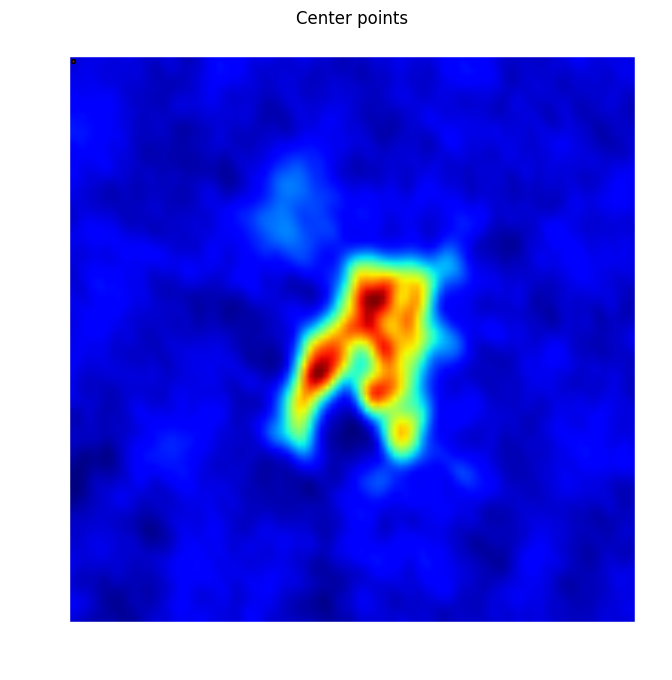

In [312]:
pp = sol[-1].reshape((center_points_.shape[0], 2))
points_plot(data, center_points=pp)

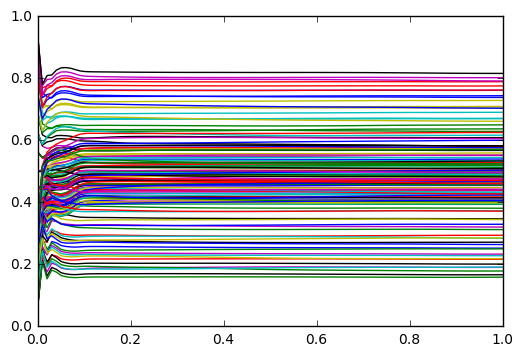

In [249]:
plt.figure()
for i in range(64*2):
    s = sol[:,i]
    plt.plot(time_grid,s)

## Fixed points second try

In [635]:
_xe = np.linspace(0., 1., 15)[1:-1]
_ye = np.linspace(0., 1., 15)[1:-1]
Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
xe = Xe.ravel(); ye = Ye.ravel()
center_points = np.hstack((xe.reshape(-1,1), ye.reshape(-1,1)))

In [636]:
_xe = np.linspace(0., 1., 12)[1:-1]
_ye = np.linspace(0., 1., 12)[1:-1]
Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
xe = Xe.ravel(); ye = Ye.ravel()
fixed_points = np.hstack((xe.reshape(-1,1), ye.reshape(-1,1)))

In [637]:
fixed_points.shape

(100, 2)

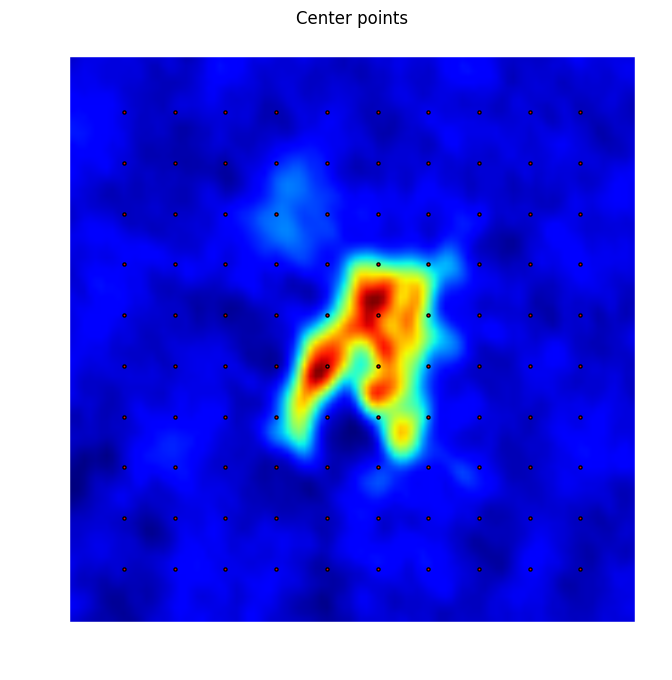

In [616]:
points_plot(data, center_points=fixed_points)

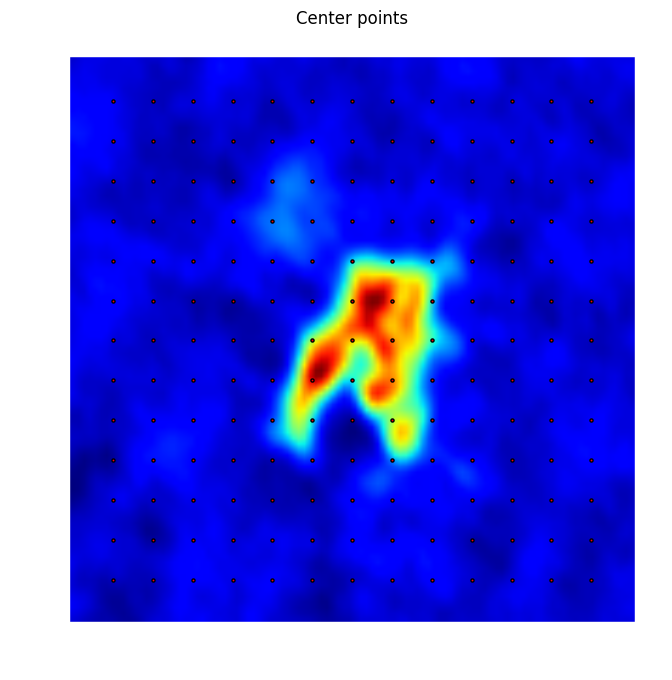

In [617]:
points_plot(data, center_points=center_points)

In [618]:
center_points_ = np.vstack((center_points, fixed_points))

In [398]:
aux2 = center_points_[:10]
print(aux2)

[[ 0.07142857  0.07142857]
 [ 0.14285714  0.07142857]
 [ 0.21428571  0.07142857]
 [ 0.28571429  0.07142857]
 [ 0.35714286  0.07142857]
 [ 0.42857143  0.07142857]
 [ 0.5         0.07142857]
 [ 0.57142857  0.07142857]
 [ 0.64285714  0.07142857]
 [ 0.71428571  0.07142857]]


In [390]:
aux2[-3:]

array([[ 0.57142857,  0.07142857],
       [ 0.64285714,  0.07142857],
       [ 0.71428571,  0.07142857]])

In [388]:
aux = center_points_[:10].flatten()
print(aux)

[ 0.07142857  0.07142857  0.14285714  0.07142857  0.21428571  0.07142857
  0.28571429  0.07142857  0.35714286  0.07142857  0.42857143  0.07142857
  0.5         0.07142857  0.57142857  0.07142857  0.64285714  0.07142857
  0.71428571  0.07142857]


In [381]:
f1 , f2 = aux2[:,0], aux2[:,1]

In [382]:
print(f1,f2)

(array([ 0.07142857,  0.14285714,  0.21428571,  0.28571429,  0.35714286,
        0.42857143,  0.5       ,  0.57142857,  0.64285714,  0.71428571]), array([ 0.07142857,  0.07142857,  0.07142857,  0.07142857,  0.07142857,
        0.07142857,  0.07142857,  0.07142857,  0.07142857,  0.07142857]))


In [389]:
print(np.vstack((f1,f2)).T.ravel())


[ 0.07142857  0.07142857  0.14285714  0.07142857  0.21428571  0.07142857
  0.28571429  0.07142857  0.35714286  0.07142857  0.42857143  0.07142857
  0.5         0.07142857  0.57142857  0.07142857  0.64285714  0.07142857
  0.71428571  0.07142857]


In [377]:
aux.reshape((10,2))

array([[ 0.07142857,  0.07142857],
       [ 0.14285714,  0.07142857],
       [ 0.21428571,  0.07142857],
       [ 0.28571429,  0.07142857],
       [ 0.35714286,  0.07142857],
       [ 0.42857143,  0.07142857],
       [ 0.5       ,  0.07142857],
       [ 0.57142857,  0.07142857],
       [ 0.64285714,  0.07142857],
       [ 0.71428571,  0.07142857]])

In [638]:
ap = APoints(center_points.shape[0], dfunc, gx_func, gy_func,  
             n_fixed=fixed_points.shape[0], alpha=10.)
time_grid = np.linspace(0., 50., 100)
sol = sp.integrate.odeint(ap.F, center_points.flatten(), time_grid)

/home/martin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


In [639]:
pp = sol[-1].reshape((center_points.shape[0], 2))
#pp

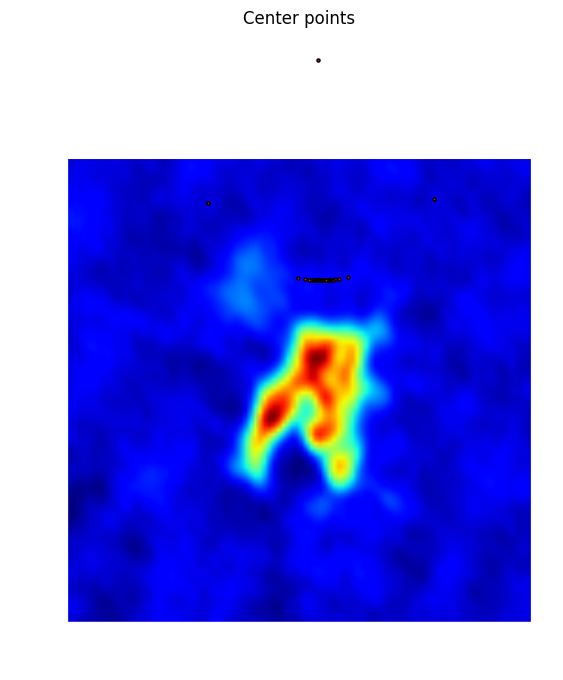

In [623]:
points_plot(data, center_points=pp)

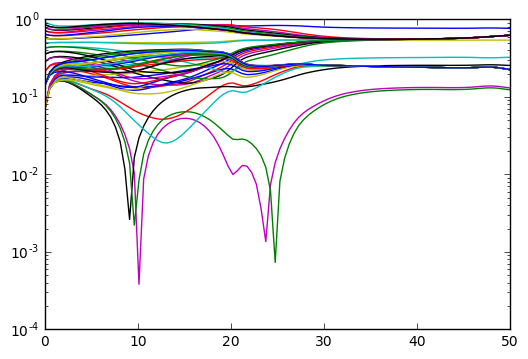

In [631]:
plt.figure()
for i in range(25*2):
    s = sol[:,i]
    plt.semilogy(time_grid, np.abs(s))

In [589]:
from ipywidgets import interact

In [640]:
def animate_particles(n):
    pp = sol[n].reshape((center_points.shape[0], 2))
    points_plot(data, center_points=pp)

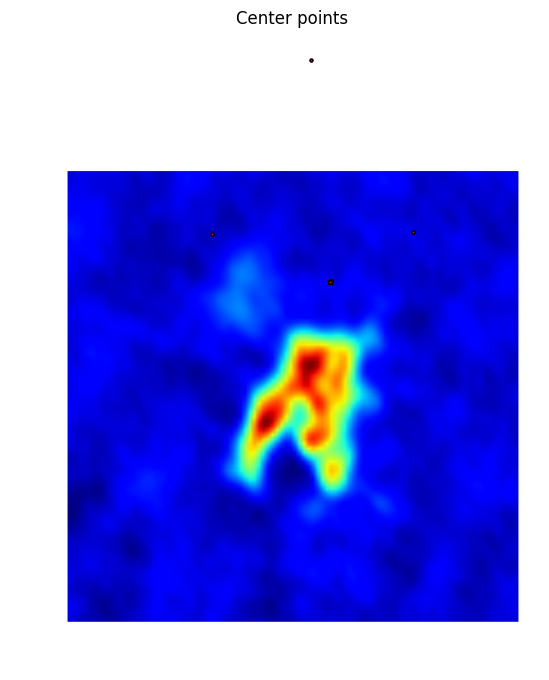

In [641]:
interact(animate_particles, n=(0,sol.shape[0]-1))